In [61]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [62]:
#Load the data
print("-------------------------------- Load IS --------------------------------")
name_experiment_is = "is_phi_phi_gk"
path_start = "./outputs/" + name_experiment_is + "/"
lst_data_is = []
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_is.append(json.load(file))
                    print("Loaded: " + path)
print("-------------------------------- Load MH --------------------------------")
name_experiment_mh = "metropolis_phi_phi_gk"
path_start = "./outputs/" + name_experiment_mh + "/"
lst_data_mh = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_mh.append(json.load(file))
                    print("Loaded: " + path)


-------------------------------- Load IS --------------------------------
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-47-02_438/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-58-10_444/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-56-48_442/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-54-50_440/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-56-10_441/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-58-54_445/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-57-35_443/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-54-15_439/all.json
-------------------------------- Load MH --------------------------------
Loaded: ./outputs/metropolis_phi_phi_gk/2024-08-21/09-02-54_438/all.json


In [63]:
# For fair comparison it is better to compare with the same true rule
true_rule = lst_data_mh[0]["true_rule"]
for data in lst_data_mh + lst_data_is:
    assert data["true_rule"] == true_rule
    print(len(data["rules"]))

1608
179
185
184
182
185
189
191
188


In [64]:
# Reconstruct all rules IS
all_rules_is = []
all_likelihoods_is = []
all_weights_is = []
for data in lst_data_is:
    all_rules_is.append(np.repeat(data["rules"], data["metrics"]["counts"]))
    all_likelihoods_is.append(np.repeat(data["likelihoods"], data["metrics"]["counts"]))
    all_weights_is.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
all_rules_is = np.stack(all_rules_is)
all_likelihoods_is = np.stack(all_likelihoods_is)
all_weights_is = np.stack(all_weights_is)

In [65]:
# Reconstruct all rules MH
all_rules_mh = []
all_likelihoods_mh = []
all_weights_mh = []
all_prev_rules_ind_mh = []
for data in lst_data_mh:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules_mh.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods_mh.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights_mh.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind_mh.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules_mh = np.concatenate(all_rules_mh, axis=0)
all_likelihoods_mh = np.concatenate(all_likelihoods_mh, axis=0)
all_weights_mh = np.concatenate(all_weights_mh, axis=0)
all_prev_rules_ind_mh = np.concatenate(all_prev_rules_ind_mh, axis=0)

In [69]:
# Compare best rule for IS and MH
# Best rules of each method
best_taken = 50
best_rules_ind_mh = np.argsort(-all_likelihoods_mh.flatten())[:best_taken]
best_rules_ind_is = np.argsort(-all_likelihoods_is.flatten())[:best_taken]
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten()[best_rules_ind_mh], all_likelihoods_is.flatten()[best_rules_ind_is]])
all_rules = np.concatenate([all_rules_mh.flatten()[best_rules_ind_mh], all_rules_is.flatten()[best_rules_ind_is]])
indices = np.argsort(-all_likelihoods)
for ind in indices:
    if ind < best_taken:
        color_start = "\x1b[31m"
        color_end = "\x1b[0m"
    else:
        color_start = "\033[92m"
        color_end = "\033[0m"
    print(
        f"{color_start}-----rule-----:{ind}:   {repr(all_rules[ind])}, likelihood: {all_likelihoods[ind]:2f}{color_end}"
    )

-----rule-----:0:   'Door is opened when holding a green key.', likelihood: -0.272992
-----rule-----:1:   'The rule for opening the door is holding a green key, regardless of its size.', likelihood: -0.280149
-----rule-----:2:   'The rule for the door is: "The door opens when a green key of any size is used."', likelihood: -0.280887
-----rule-----:3:   'The rule is: The door opens when holding a green object, specifically a green key.', likelihood: -0.285897
-----rule-----:4:   'The rule is: The door opens when a green object, specifically a key, is used.', likelihood: -0.286274
-----rule-----:50:   'The rule for the door is that it opens only when you are holding a green key, regardless of its size or color.', likelihood: -0.286453
-----rule-----:5:   'The rule for the door is: The door opens when a green key is used.', likelihood: -0.292386
-----rule-----:6:   'The rule is: the door opens when holding a green object, specifically a green key.', likelihood: -0.292980
-----rule-----:7:

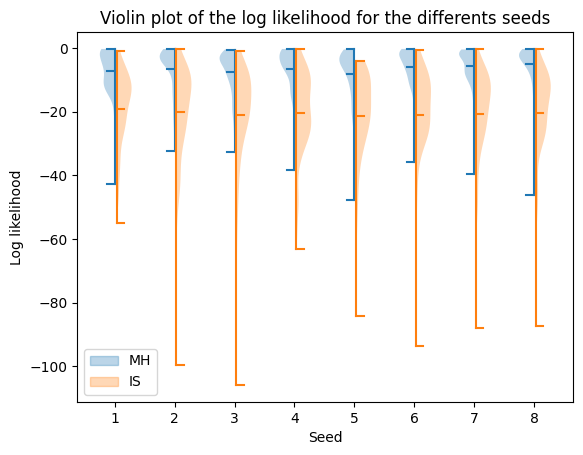

In [126]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

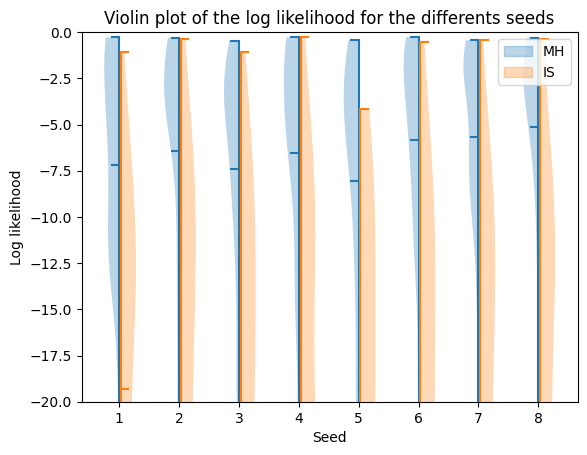

In [127]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
fig,ax = plt.subplots()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
ax.set_ylim(-20,0)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

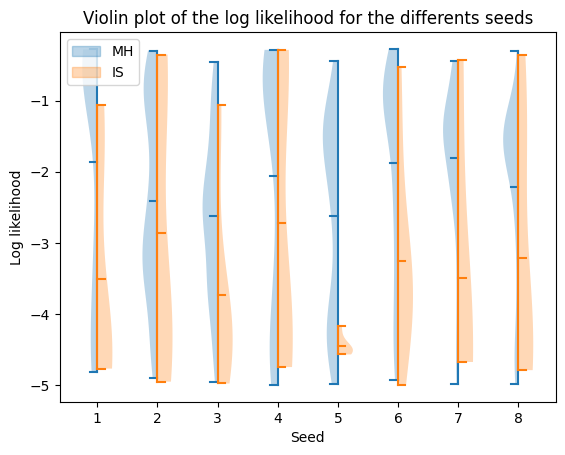

In [139]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms for high likelihoods
min_likelihood=-5
high_likelihoods_mh = [all_likelihoods_mh[row][all_likelihoods_mh[row] > min_likelihood] for row in range(len(all_likelihoods_mh))]
high_likelihoods_is = [all_likelihoods_is[row][all_likelihoods_is[row] > min_likelihood] for row in range(len(all_likelihoods_is))]
fig,ax = plt.subplots()
color_mh = plt.violinplot(high_likelihoods_mh, showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(high_likelihoods_is, showmeans=True, side="high")["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()